In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import ast
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import os
from IPython.display import FileLink

In [3]:
filepaths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        filepaths.append(os.path.join(dirname, filename))

/kaggle/input/the-movies-dataset/ratings.csv
/kaggle/input/the-movies-dataset/links_small.csv
/kaggle/input/the-movies-dataset/credits.csv
/kaggle/input/the-movies-dataset/keywords.csv
/kaggle/input/the-movies-dataset/movies_metadata.csv
/kaggle/input/the-movies-dataset/ratings_small.csv
/kaggle/input/the-movies-dataset/links.csv


# Data Extraction/Engineering

In [4]:
credits_df = pd.read_csv(filepaths[2])
keywords_df = pd.read_csv(filepaths[3])
links_small_df = pd.read_csv(filepaths[1])
links_df = pd.read_csv(filepaths[6])
movies_metadata_df = pd.read_csv(filepaths[4])
ratings_small_df = pd.read_csv(filepaths[5])
ratings_df = pd.read_csv(filepaths[0])

In [5]:
credits_df_grouped_by_dtype = credits_df.columns.to_series().groupby(credits_df.dtypes).groups
keywords_df_grouped_by_dtype = keywords_df.columns.to_series().groupby(keywords_df.dtypes).groups
links_small_df_grouped_by_dtype = links_small_df.columns.to_series().groupby(links_small_df.dtypes).groups
links_df_grouped_by_dtype = links_df.columns.to_series().groupby(links_df.dtypes).groups
movies_metadata_df_grouped_by_dtype = movies_metadata_df.columns.to_series().groupby(movies_metadata_df.dtypes).groups
ratings_small_df_grouped_by_dtype = ratings_small_df.columns.to_series().groupby(ratings_small_df.dtypes).groups
ratings_df_grouped_by_dtype = ratings_df.columns.to_series().groupby(ratings_df.dtypes).groups

print('Credits: ' + str({key.name: val for key, val in credits_df_grouped_by_dtype.items()}) + ' ' + str(credits_df.shape))
print('Keywords: ' + str({key.name: val for key, val in keywords_df_grouped_by_dtype.items()}) + ' ' + str(keywords_df.shape))
print('Links Small: '+ str({key.name: val for key, val in links_small_df_grouped_by_dtype.items()}) + ' ' + str(links_small_df.shape))
print('Links: ' + str({key.name: val for key, val in links_df_grouped_by_dtype.items()}) + ' ' + str(links_df.shape))
print('Movies Metadata: ' + str({key.name: val for key, val in movies_metadata_df_grouped_by_dtype.items()}) + ' ' + str(movies_metadata_df.shape))
print('Ratings Small: ' + str({key.name: val for key, val in ratings_small_df_grouped_by_dtype.items()}) + ' ' + str(ratings_small_df.shape))
print('Ratings: ' + str({key.name: val for key, val in ratings_df_grouped_by_dtype.items()}) + ' ' + str(ratings_df.shape))

Credits: {'int64': Index(['id'], dtype='object'), 'object': Index(['cast', 'crew'], dtype='object')} (45476, 3)
Keywords: {'int64': Index(['id'], dtype='object'), 'object': Index(['keywords'], dtype='object')} (46419, 2)
Links Small: {'int64': Index(['movieId', 'imdbId'], dtype='object'), 'float64': Index(['tmdbId'], dtype='object')} (9125, 3)
Links: {'int64': Index(['movieId', 'imdbId'], dtype='object'), 'float64': Index(['tmdbId'], dtype='object')} (45843, 3)
Movies Metadata: {'float64': Index(['revenue', 'runtime', 'vote_average', 'vote_count'], dtype='object'), 'object': Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'spoken_languages', 'status',
       'tagline', 'title', 'video'],
      dtype='object')} (45466, 24)
Ratings Small: {'int64': Index(['userId', 'movieId', 'timesta

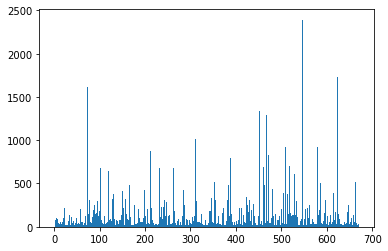

In [6]:
unique_users = ratings_small_df['userId'].unique()
plt.hist(ratings_small_df['userId'], bins=len(unique_users))
plt.show()

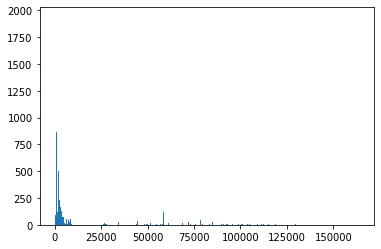

In [7]:
unique_movies = ratings_small_df['movieId'].unique()
plt.hist(ratings_small_df['movieId'], bins=len(unique_movies))
plt.show()

In [8]:
avg_num_genres = np.average([len(ast.literal_eval(m)) for m in movies_metadata_df['genres']])
print(avg_num_genres)

2.0038270355870322


In [9]:
for i, val in enumerate(movies_metadata_df.id):
  try:
    val_int = int(val)
  except Exception:
    movies_metadata_df.drop(i, inplace=True)

In [10]:
movies_metadata_df.id = movies_metadata_df.id.astype(int)
merged_df = credits_df.merge(movies_metadata_df, on='id').merge(keywords_df, on='id')

In [11]:
merged_df.shape

(46628, 27)

In [12]:
merged_df.head()

,cast,crew,id,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,keywords
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,tt0114709,en,...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,tt0113497,en,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,tt0113228,en,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0114885,en,...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt0113041,en,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [13]:
merged_df.keys()

Index(['cast', 'crew', 'id', 'adult', 'belongs_to_collection', 'budget',
       'genres', 'homepage', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'keywords'],
      dtype='object')

In [14]:
merged_df['cast'].iloc[0]

"[{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gender': 2, 'id': 7167, 'name': 'Don Rickles', 'order': 2, 'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}, {'cast_id': 17, 'character': 'Slinky Dog (voice)', 'credit_id': '52fe4284c3a36847f8024fa1', 'gender': 2, 'id': 12899, 'name': 'Jim Varney', 'order': 3, 'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'}, {'cast_id': 18, 'character': 'Rex (voice)', 'credit_id': '52fe4284c3a36847f8024fa5', 'gender': 2, 'id': 12900, 'name': 'Wallace Shawn', 'order': 4, 'profile_path': '/oGE6JqPP2xH4t

In [15]:
merged_df['crew'].iloc[0]

'[{\'credit_id\': \'52fe4284c3a36847f8024f49\', \'department\': \'Directing\', \'gender\': 2, \'id\': 7879, \'job\': \'Director\', \'name\': \'John Lasseter\', \'profile_path\': \'/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f4f\', \'department\': \'Writing\', \'gender\': 2, \'id\': 12891, \'job\': \'Screenplay\', \'name\': \'Joss Whedon\', \'profile_path\': \'/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f55\', \'department\': \'Writing\', \'gender\': 2, \'id\': 7, \'job\': \'Screenplay\', \'name\': \'Andrew Stanton\', \'profile_path\': \'/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f5b\', \'department\': \'Writing\', \'gender\': 2, \'id\': 12892, \'job\': \'Screenplay\', \'name\': \'Joel Cohen\', \'profile_path\': \'/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f61\', \'department\': \'Writing\', \'gender\': 0, \'id\': 12893, \'job\': \'Screenplay\', \'name\': \'A

In [16]:
merged_df['keywords'].iloc[0]

"[{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]"

In [17]:
merged_df['genres'].iloc[0]

"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"

In [18]:
def get_actor_name(elem):
    arr = ast.literal_eval(elem)
    count = 0
    actors = []
    for val in arr:
        if count == 3:
            break
        actors.append(val['name'])
        count += 1

    return actors

def get_director_name(elem):
    arr = ast.literal_eval(elem)
    count = 0
    director = ''
    for val in arr:
        if val['job'] == 'Director':
            director = val['name']
            count += 1

    return director

def get_keywords(elem):
    arr = ast.literal_eval(elem)
    keywords = []
    for val in arr:
        keywords.append(val['name'])

    return keywords

def get_genres(elem):
    arr = ast.literal_eval(elem)
    genres = []
    for val in arr:
        genres.append(val['name'])

    return genres

def weighted_rating(df, m, C):
    v = df['vote_count']
    R = df['vote_average']
    return ((v*R)/(v+m)+(m*C)/(m+v))

In [37]:
def generate_dataset(df, m, C):
    main_actors = df['cast'].apply(get_actor_name)
    directors = df['crew'].apply(get_director_name)
    keywords = df['keywords'].apply(get_keywords)
    genres = df['genres'].apply(get_genres)
    scores = df[['vote_count', 'vote_average']].apply(weighted_rating, axis=1, args=(m, C,))

    df_dict = {'main_actors': main_actors, 'directors': directors, 'genres': genres, 'keywords': keywords, 'scores': scores}
    new_df = pd.DataFrame(df_dict)
    new_df['overview'] = df['overview']
    return new_df.reset_index(drop=True)

In [38]:
C = merged_df['vote_average'].mean()
m = merged_df['vote_count'].quantile(0.9)
truncated_df = merged_df.copy().loc[merged_df['vote_count'] >= m]

data_df = generate_dataset(truncated_df, m, C)
data_df

,main_actors,directors,genres,keywords,scores,overview
0,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter,"[Animation, Comedy, Family]","[jealousy, toy, boy, friendship, friends, riva...",7.641524,"Led by Woody, Andy's toys live happily in his ..."
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston,"[Adventure, Fantasy, Family]","[board game, disappearance, based on children'...",6.821771,When siblings Judy and Peter discover an encha...
2,"[Steve Martin, Diane Keaton, Martin Short]",Charles Shyer,[Comedy],"[baby, midlife crisis, confidence, aging, daug...",5.658145,Just when George Banks has recovered from his ...
3,"[Al Pacino, Robert De Niro, Val Kilmer]",Michael Mann,"[Action, Crime, Drama, Thriller]","[robbery, detective, bank, obsession, chase, s...",7.540465,"Obsessive master thief, Neil McCauley leads a ..."
4,"[Jean-Claude Van Damme, Powers Boothe, Dorian ...",Peter Hyams,"[Action, Adventure, Thriller]","[terrorist, hostage, explosive, vice president]",5.552817,International action superstar Jean Claude Van...
...,...,...,...,...,...,...
4675,"[Nikolaj Coster-Waldau, Jon Bernthal, Lake Bell]",Ric Roman Waugh,"[Drama, Crime, Thriller]","[tattoo, prison, california, desperation, shoo...",6.481312,A newly-released prison gangster is forced by ...
4676,"[Jean Dujardin, Clovis Cornillac, Bruno Salomone]",James Huth,[Comedy],[],4.947562,"Brice is back. The world has changed, but not ..."
4677,"[Regina Hall, Queen Latifah, Jada Pinkett Smith]",Malcolm D. Lee,[Comedy],[],6.677103,Four girlfriends take a trip to New Orleans fo...
4678,"[Dove Cameron, Sofia Carson, Cameron Boyce]",Kenny Ortega,"[TV Movie, Family, Action, Comedy, Music, Adve...","[fairy tale, villain, musical, teen movie, tee...",6.599173,When the pressure to be royal becomes too much...


In [57]:
# These functions, I used from (other than compute_precision_and_recall)
# https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system#Content-Based-Filtering
def clean_data(elem):
    if type(elem) == list:
        return [str.lower(x.replace(" ", "")) for x in elem]
    else:
        if type(elem) == str:
            return str.lower(elem.replace(" ", ""))
        else:
            return ""

def create_word_soup(elem):
    return ' '.join(elem['keywords']) + ' ' + ' '.join(elem['main_actors']) + ' ' + elem['directors'] + ' ' + ' '.join(elem['genres']) + ' ' + elem['overview']

def get_recommendations(df, movie, similarity_measure):
    indices = pd.Series(df.index, index=df['title']).drop_duplicates()
    idx = indices[movie]

    sim_scores = list(enumerate(similarity_measure[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]

    return df['title'].iloc[movie_indices]

def compute_precision_and_recall(df, recommendations):
    precision = 1/len(recommendations)
    recall = 1/len(df[df['vote_average'] >= 7.5])
    prec_num = 0
    rec_num = 0
    for rec in recommendations:
        if all(df[df['title'] == rec]['vote_average'] >= 7.5):
            prec_num += 1
            rec_num += 1
            
    precision *= prec_num
    recall *= rec_num
    return precision, recall

def get_random_recommendation(df, similarity_measure):
    rand_idx = np.random.randint(0, len(df))
    rand_movie = df.iloc[rand_idx]['title']
    try:
        return get_recommendations(df, rand_movie, similarity_measure), rand_movie
    except Exception:
        return get_random_recommendation(df, similarity_measure)

In [58]:
features = ["main_actors", "directors", "genres", "keywords", "overview"]

for f in features:
    data_df[f] = data_df[f].apply(clean_data)

data_df['word_soup'] = data_df.apply(create_word_soup, axis=1)

In [59]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(data_df['word_soup'])

sim = cosine_similarity(count_matrix, count_matrix)

In [62]:
random_recommendations, rand_movie = get_random_recommendation(merged_df.loc[merged_df['vote_count'] >= m].reset_index(drop=True), sim)
print(f'The recommendations for {rand_movie} is:\n{random_recommendations}')

The recommendations for Rambo III is:
767     Rambo: First Blood Part II
2420                         Rambo
2204                    The Marine
768                    First Blood
3171            Bullet to the Head
4495         The Magnificent Seven
1285                       Lock Up
2811                    Green Zone
2624                     Ong Bak 2
2891               The Expendables
Name: title, dtype: object


### The following cell gives the precision and recall for the model

In [64]:
avg_precision, avg_recall = 0, 0
skip_count = 0
for i, row in merged_df.loc[merged_df['vote_count'] >= m].iterrows():
    try:
        recommendations = get_recommendations(merged_df.loc[merged_df['vote_count'] >= m], row['title'], sim)
        precision, recall = compute_precision_and_recall(merged_df.loc[merged_df['vote_count'] >= m], recommendations)
    except Exception:
        skip_count += 1
        continue
    
    avg_precision += precision
    avg_recall += recall
    
avg_precision /= (len(merged_df.loc[merged_df['vote_count'] >= m])-skip_count)
avg_recall /= (len(merged_df.loc[merged_df['vote_count'] >= m])-skip_count)
print(avg_precision, avg_recall)

0.08366854384553465 0.0014181109126361906


# Continuous Bag-of-Words Embedding

In [65]:
dev = None
if torch.cuda.is_available():
  dev = torch.device('cuda:0')
else:
  dev = torch.device('cpu')

print(dev)

cuda:0


In [66]:
C = merged_df['vote_average'].mean()
m = merged_df['vote_count'].quantile(0.9)
truncated_df = merged_df.copy().loc[merged_df['vote_count'] >= m]

data_df = generate_dataset(truncated_df, m, C)
data_df

,main_actors,directors,genres,keywords,scores,overview
0,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter,"[Animation, Comedy, Family]","[jealousy, toy, boy, friendship, friends, riva...",7.641524,"Led by Woody, Andy's toys live happily in his ..."
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston,"[Adventure, Fantasy, Family]","[board game, disappearance, based on children'...",6.821771,When siblings Judy and Peter discover an encha...
2,"[Steve Martin, Diane Keaton, Martin Short]",Charles Shyer,[Comedy],"[baby, midlife crisis, confidence, aging, daug...",5.658145,Just when George Banks has recovered from his ...
3,"[Al Pacino, Robert De Niro, Val Kilmer]",Michael Mann,"[Action, Crime, Drama, Thriller]","[robbery, detective, bank, obsession, chase, s...",7.540465,"Obsessive master thief, Neil McCauley leads a ..."
4,"[Jean-Claude Van Damme, Powers Boothe, Dorian ...",Peter Hyams,"[Action, Adventure, Thriller]","[terrorist, hostage, explosive, vice president]",5.552817,International action superstar Jean Claude Van...
...,...,...,...,...,...,...
4675,"[Nikolaj Coster-Waldau, Jon Bernthal, Lake Bell]",Ric Roman Waugh,"[Drama, Crime, Thriller]","[tattoo, prison, california, desperation, shoo...",6.481312,A newly-released prison gangster is forced by ...
4676,"[Jean Dujardin, Clovis Cornillac, Bruno Salomone]",James Huth,[Comedy],[],4.947562,"Brice is back. The world has changed, but not ..."
4677,"[Regina Hall, Queen Latifah, Jada Pinkett Smith]",Malcolm D. Lee,[Comedy],[],6.677103,Four girlfriends take a trip to New Orleans fo...
4678,"[Dove Cameron, Sofia Carson, Cameron Boyce]",Kenny Ortega,"[TV Movie, Family, Action, Comedy, Music, Adve...","[fairy tale, villain, musical, teen movie, tee...",6.599173,When the pressure to be royal becomes too much...


In [67]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [68]:
def clean_overview(elem):
    stop_words = set(stopwords.words('english'))
    no_punc = "".join([char for char in elem if char not in string.punctuation])
    word_tokens = word_tokenize(no_punc)
    filtered_sentence = [word.lower() for word in word_tokens if not word.lower() in stop_words]
    return filtered_sentence

In [69]:
data_df['overview'] = data_df['overview'].astype(str).apply(clean_overview)
data_df['overview'].iloc[0]

['led',
 'woody',
 'andys',
 'toys',
 'live',
 'happily',
 'room',
 'andys',
 'birthday',
 'brings',
 'buzz',
 'lightyear',
 'onto',
 'scene',
 'afraid',
 'losing',
 'place',
 'andys',
 'heart',
 'woody',
 'plots',
 'buzz',
 'circumstances',
 'separate',
 'buzz',
 'woody',
 'owner',
 'duo',
 'eventually',
 'learns',
 'put',
 'aside',
 'differences']

In [70]:
drop_indices = [i for i, row in data_df.iterrows() if len(set(row['overview'])) < 5]
data_df.drop(drop_indices, inplace=True)

In [71]:
data_df.shape

(4673, 6)

In [72]:
raw_train, raw_test = train_test_split(data_df['overview'], test_size=0.2)

In [73]:
# For pytorch implementations, I used templates given: https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
# I adjusted to properly fit my problem
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
raw_text = raw_train.values.tolist()

train_vocab = [set(overview) for overview in raw_text]
train_vocab_size = 0
for overview in train_vocab:
    train_vocab_size += len(overview)

train_word_to_ix = {word: i for overview in train_vocab for i, word in enumerate(overview)}
train_data = []
for i in range(len(raw_text)):
    for j in range(CONTEXT_SIZE, len(raw_text[i]) - CONTEXT_SIZE):
        context = (
            [raw_text[i][j - k - 1] for k in range(CONTEXT_SIZE)]
            + [raw_text[i][j + k + 1] for k in range(CONTEXT_SIZE)]
        )
        target = raw_text[i][j]
        train_data.append((context, target))
print(train_data[:5], len(train_data))

[(['two', 'adventures', 'highway', 'patrol'], 'california'), (['california', 'two', 'patrol', 'motorcycle'], 'highway'), (['highway', 'california', 'motorcycle', 'officers'], 'patrol'), (['patrol', 'highway', 'officers', 'make'], 'motorcycle'), (['motorcycle', 'patrol', 'make', 'rounds'], 'officers')] 93722


In [74]:
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

In [75]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, max_norm=1)
        self.linear = nn.Linear(2*context_size*embedding_dim, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear(embeds))
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [76]:
losses = []
loss_function = nn.CrossEntropyLoss()
model = CBOW(train_vocab_size, EMBEDDING_DIM, CONTEXT_SIZE)
model.to(dev)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(25):
    total_loss = 0
    for context, target in train_data:
        context_vec = make_context_vector(context, train_word_to_ix)
        context_vec = context_vec.to(dev)
        model.zero_grad()

        log_probs = model(context_vec)
        target_tensor = torch.tensor([train_word_to_ix[target]], dtype=torch.long).to(dev)
        loss = loss_function(log_probs, target_tensor)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f'Epoch {epoch+1}: Loss - {total_loss}')
    losses.append(total_loss)

Epoch 1: Loss - 595194.976877451
Epoch 2: Loss - 576266.7176058292
Epoch 3: Loss - 576072.4346804619
Epoch 4: Loss - 575921.6413547993
Epoch 5: Loss - 575820.3161590099
Epoch 6: Loss - 575758.1566300392
Epoch 7: Loss - 575718.3585839272
Epoch 8: Loss - 575685.2631833553
Epoch 9: Loss - 575652.1599123478
Epoch 10: Loss - 575626.9394865036
Epoch 11: Loss - 575613.1164290905
Epoch 12: Loss - 575596.195555687
Epoch 13: Loss - 575572.812253952
Epoch 14: Loss - 575546.1571984291
Epoch 15: Loss - 575518.6014053822
Epoch 16: Loss - 575501.9234721661
Epoch 17: Loss - 575490.3175544739
Epoch 18: Loss - 575481.7116897106
Epoch 19: Loss - 575468.898175478
Epoch 20: Loss - 575447.4503538609
Epoch 21: Loss - 575436.5479750633
Epoch 22: Loss - 575433.074580431
Epoch 23: Loss - 575424.8500528336
Epoch 24: Loss - 575415.1503193378
Epoch 25: Loss - 575405.1764130592


In [78]:
raw_train.iloc[0]

['adventures',
 'two',
 'california',
 'highway',
 'patrol',
 'motorcycle',
 'officers',
 'make',
 'rounds',
 'freeways',
 'los',
 'angeles']

In [79]:
w2vec_matrix = np.zeros((len(raw_train), EMBEDDING_DIM))
for i, overview in enumerate(raw_train):
    combined_weight = np.zeros((EMBEDDING_DIM,))
    for word in overview:
        combined_weight += model.embeddings.weight[train_word_to_ix[word]].cpu().detach().numpy()
        
    length = len(overview)
    combined_weight /= length
    w2vec_matrix[i] = combined_weight
    
w2vec_matrix.shape

(3738, 10)

In [80]:
sim = cosine_similarity(w2vec_matrix, w2vec_matrix)
random_recommendations, rand_movie = get_random_recommendation(merged_df.loc[merged_df['vote_count'] >= m].reset_index(drop=True), sim)
print(f'The recommendations for {rand_movie} is:\n{random_recommendations}')

The recommendations for The Bourne Ultimatum is:
2163      Talladega Nights: The Ballad of Ricky Bobby
45                             The Basketball Diaries
464                               Beverly Hills Ninja
2917    Legend of the Guardians: The Owls of Ga'Hoole
1106                                          Mad Max
3370                                       Life of Pi
1925               The Life Aquatic with Steve Zissou
2780            The Girl Who Kicked the Hornet's Nest
603                  Friday the 13th: A New Beginning
2635                                   Fast & Furious
Name: title, dtype: object


In [81]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
raw_text = raw_test.values.tolist()

test_vocab = [set(overview) for overview in raw_text]
test_vocab_size = 0
for overview in test_vocab:
    test_vocab_size += len(overview)

test_word_to_ix = {word: i for overview in test_vocab for i, word in enumerate(overview)}
test_data = []
for i in range(len(raw_text)):
    for j in range(CONTEXT_SIZE, len(raw_text[i]) - CONTEXT_SIZE):
        context = (
            [raw_text[i][j - k - 1] for k in range(CONTEXT_SIZE)]
            + [raw_text[i][j + k + 1] for k in range(CONTEXT_SIZE)]
        )
        target = raw_text[i][j]
        test_data.append((context, target))
print(test_data[:5], len(test_data))

[(['minutes', '88', 'college', 'professor'], 'focuses'), (['focuses', 'minutes', 'professor', 'pacino'], 'college'), (['college', 'focuses', 'pacino', 'moonlights'], 'professor'), (['professor', 'college', 'moonlights', 'forensic'], 'pacino'), (['pacino', 'professor', 'forensic', 'psychiatrist'], 'moonlights')] 23175


In [82]:
w2vec_matrix_test = np.zeros((len(raw_test), EMBEDDING_DIM))
for i, overview in enumerate(raw_test):
    combined_weight = np.zeros((EMBEDDING_DIM,))
    for word in overview:
        combined_weight += model.embeddings.weight[test_word_to_ix[word]].cpu().detach().numpy()
        
    length = len(overview)
    combined_weight /= length
    w2vec_matrix_test[i] = combined_weight
    
w2vec_matrix_test.shape

(935, 10)

In [83]:
os.chdir(r'/kaggle/working')

df = merged_df.loc[merged_df['vote_count'] >= m].reset_index(drop=True)
df.to_csv(r'truncated_merged_df.csv')

In [84]:
FileLink(r'truncated_merged_df.csv')

/kaggle/working/truncated_merged_df.csv

In [85]:
w2vec_sim = cosine_similarity(w2vec_matrix_test, w2vec_matrix_test)

In [86]:
w2vec_sim_df = pd.DataFrame(w2vec_sim)
w2vec_sim_df.to_csv(r'w2vec_sim.csv')

In [87]:
FileLink(r'w2vec_sim.csv')

/kaggle/working/w2vec_sim.csv

In [88]:
w2vec_recommendations = get_recommendations(merged_df.loc[merged_df['vote_count'] >= m], 'Toy Story', w2vec_sim)
w2vec_recommendations

1186                           Apocalypse Now
352               Four Weddings and a Funeral
1241                            Groundhog Day
262                       Legends of the Fall
1827                              Buffalo '66
1528                             Men in Black
715                                 The Craft
2628                             Ghostbusters
2595    Austin Powers: The Spy Who Shagged Me
585                                    Batman
Name: title, dtype: object

In [89]:
compute_precision_and_recall(merged_df.loc[merged_df['vote_count'] >= m], w2vec_recommendations)

(0.1, 0.001694915254237288)

In [90]:
avg_precision, avg_recall = 0, 0
skip_count = 0
for i, row in merged_df.loc[merged_df['vote_count'] >= m].iterrows():
    try:
        recommendations = get_recommendations(merged_df.loc[merged_df['vote_count'] >= m], row['title'], sim)
        precision, recall = compute_precision_and_recall(merged_df.loc[merged_df['vote_count'] >= m], recommendations)
    except Exception:
        skip_count += 1
        continue
    
    avg_precision += precision
    avg_recall += recall
    
avg_precision /= (len(merged_df.loc[merged_df['vote_count'] >= m])-skip_count)
avg_recall /= (len(merged_df.loc[merged_df['vote_count'] >= m])-skip_count)
print(avg_precision, avg_recall)

0.130269266480965 0.0022079536691689185
